In [2]:
import polars as pl
from polars import col
from bill_law_similarity.vector import preprocess, compute_cosine_similarity
from bill_law_similarity.docu_toads import docu_toads_similarity
from bill_law_similarity.bow import bow_overlap, bow_pos_overlap
from bill_law_similarity.string_diff import diff
from bill_law_similarity.deep import BertSimilarity
from bill_law_similarity.string_diff import sw_align
import jaro

%load_ext autoreload
%autoreload 2

/home/peter/anaconda3/envs/billlaw/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_df(type, lang="de", preprocessing=True):
    df = pl.read_csv(f"data/annotated/{type}_sub_sec_pairs.csv").rename(
        {"sec_a_text": "bill_text", "sec_b_text": "law_text"}
    )
    if not preprocessing:
        return df
    preprocessed = preprocess(df, lang)
    return preprocessed


In [21]:
def comparison_wrapper(col_a, col_b, func, name):
    return (
        pl.struct([pl.col(col_a), pl.col(col_b)])
        .apply(lambda x_dict: func(x_dict[col_a], x_dict[col_b]))
        .alias(name)
    )


def pos_bow_ol_wrapper(col_a, col_b, col_a_tags, col_b_tags, func, name):
    return (
        pl.struct(
            [pl.col(col_a), pl.col(col_b), pl.col(col_a_tags), pl.col(col_b_tags)]
        )
        .apply(
            lambda x_dict: func(
                x_dict[col_a], x_dict[col_a_tags], x_dict[col_b], x_dict[col_b_tags]
            )
        )
        .alias(name)
    )


def similarity_metrics(df):
    bert = BertSimilarity()
    # Polars paralellizes with_columns(). For some reason, it crashes with BERT -> workaround
    df_deep = df.with_columns([comparison_wrapper("bill_sents", "law_sents", bert.bert_align, "bert_aligned")])
    df_deep = df_deep.with_columns([comparison_wrapper("bill_sents", "law_sents", bert.bert_avg_pool, "bert_avg_pool")])
    df_deep = df_deep.with_columns([comparison_wrapper("bill_sents", "law_sents", bert.bert_max_avg, "bert_max_avg")])
    df_deep = df_deep.with_columns([comparison_wrapper("bill_text", "law_text", bert.bert_cosine, "bert_full")])

    tfidf_cos_sim = compute_cosine_similarity(df)
    tfidf_cos_sim_bigram = compute_cosine_similarity(df, (2,2))
    tfidf_cos_sim_lemma = compute_cosine_similarity(df)
    tfidf_cos_sim_bigram_lemma = compute_cosine_similarity(df, (2,2))

    return df_deep.with_columns(
        [
            # pl.col(["bert_aligned", "bert_avg_pool", "bert_max_avg", "bert_full"]),
            # TF_IDF Cos-Sim
            pl.Series(tfidf_cos_sim).alias("tfidf_cos_sim"),
            pl.Series(tfidf_cos_sim_bigram).alias("tfidf_cos_sim_bigram"),
            pl.Series(tfidf_cos_sim_lemma).alias("tfidf_cos_sim_lemma"),
            pl.Series(tfidf_cos_sim_bigram_lemma).alias("tfidf_cos_sim_bigram_lemma"),
            # SW Align
            comparison_wrapper("bill_text", "law_text", sw_align, "sw_align"),
            # DocuToads
            comparison_wrapper(
                "bill_tokens", "law_tokens", docu_toads_similarity, "docu_toads"
            ),
              comparison_wrapper(
                "bill_lemmas", "law_lemmas", docu_toads_similarity, "docu_toads_lemma"
            ),
            # BOW Overlap
            comparison_wrapper("bill_tokens", "law_tokens", bow_overlap, "bow_ol"),
            comparison_wrapper(
                "bill_tokens",
                "law_tokens",
                lambda a, b: bow_overlap(a, b, 2),
                "bow_ol_bigrams",
            ),
            comparison_wrapper("bill_lemmas", "law_lemmas", bow_overlap, "bow_ol_lemma"),
            comparison_wrapper(
               "bill_lemmas", "law_lemmas",
                lambda a, b: bow_overlap(a, b, 2),
                "bow_ol_bigrams_lemma",
            ),
            # POS BOW Overlap
            pos_bow_ol_wrapper(
                "bill_tokens",
                "law_tokens",
                "bill_tags",
                "law_tags",
                bow_pos_overlap,
                "pos_bow_ol",
            ),
            pos_bow_ol_wrapper(
                "bill_tokens",
                "law_tokens",
                "bill_tags",
                "law_tags",
                lambda a, b, c, d: bow_pos_overlap(a, b, c, d, 2),
                "pos_bow_bigrams",
            ),
            pos_bow_ol_wrapper(
                "bill_lemmas",
                "law_lemmas",
                "bill_tags",
                "law_tags",
                bow_pos_overlap,
                "pos_bow_ol_lemma",
            ),
            pos_bow_ol_wrapper(
                "bill_lemmas",
                "law_lemmas",
                "bill_tags",
                "law_tags",
                lambda a, b, c, d: bow_pos_overlap(a, b, c, d, 2),
                "pos_bow_bigrams_lemma",
            ),
            # Jaro Winkler
            comparison_wrapper(
                "bill_text", "law_text", jaro.jaro_winkler_metric, "jaro_winkler"
            ),
        ]
    )#.drop(["bill_sents", "law_sents", "bill_tokens", "law_tokens", "bill_tags", "law_tags", "bill_lemmas", "law_lemmas", "sec_a_id", "sec_b_id", "sec_a_title", "sec_b_title", "bill_text", "law_text", "label"])


In [5]:
def pipeline(lang, to_csv=True):
    train = load_df("train", lang)
    train = similarity_metrics(train)
    
    val = load_df("val", lang).sample(10)
    val = similarity_metrics(val)
    
    test = load_df("test", lang)
    test = similarity_metrics(test)
    try:
        if to_csv:
            val.write_csv(f"data/results/val_metrics_{lang}.csv")
            train.write_csv(f"data/results/train_metrics_{lang}.csv")
            test.write_csv(f"data/results/test_metrics_{lang}.csv")
    except: 
        return train, val, test
    return train, val, test

In [6]:
# train_metrics_de, val_metrics_de, test_metrics_de = pipeline("de")
train_metrics_de = pl.read_csv("data/results/train_metrics_de.csv")
val_metrics_de = pl.read_csv("data/results/val_metrics_de.csv")
test_metrics_de = pl.read_csv("data/results/test_metrics_de.csv")

In [7]:
# train_metrics_en, val_metrics_en, test_metrics_en = pipeline("en")
train_metrics_en = pl.read_csv("data/results/train_metrics_en.csv")
val_metrics_en = pl.read_csv("data/results/val_metrics_en.csv")
test_metrics_en = pl.read_csv("data/results/test_metrics_en.csv")

In [8]:
test_de = load_df("test", "de", preprocessing=False).with_columns([
    pl.col("label") / 4
])
test_en = load_df("test", "en", preprocessing=False).with_columns([
    pl.col("label") / 4
])

In [6]:
# bert_distiluse = BertSimilarity()
# bert_mpnet = BertSimilarity("paraphrase-multilingual-mpnet-base-v2")
# bert_roberta = BertSimilarity("all-distilroberta-v1")
# bert_minilm = BertSimilarity("all-MiniLM-L12-v2")
# bert_vars_de = test_de.with_columns([comparison_wrapper("bill_text", "law_text", bert_distiluse.bert_cosine, "distiluse"),
#                                         comparison_wrapper("bill_text", "law_text", bert_mpnet.bert_cosine, "mpnet"),
#                                         comparison_wrapper("bill_text", "law_text", bert_roberta.bert_cosine, "roberta"),
#                                         comparison_wrapper("bill_text", "law_text", bert_minilm.bert_cosine, "minilm")
#                                      ])


In [13]:
import itertools
a = ["We prefer environmental protection over economic growth", "We prefer economic growth over environmental protection", "We prefer climate change mitigation over economic performance", "We prefer economic performance over climate change mitigation"]
# combine every two sentences
b = list(itertools.combinations(a, 2))

In [37]:
b

[('We prefer environmental protection over economic growth',
  'We prefer economic growth over environmental protection'),
 ('We prefer environmental protection over economic growth',
  'We prefer climate change mitigation over economic performance'),
 ('We prefer environmental protection over economic growth',
  'We prefer economic performance over climate change mitigation'),
 ('We prefer economic growth over environmental protection',
  'We prefer climate change mitigation over economic performance'),
 ('We prefer economic growth over environmental protection',
  'We prefer economic performance over climate change mitigation'),
 ('We prefer climate change mitigation over economic performance',
  'We prefer economic performance over climate change mitigation')]

In [40]:
example = pl.from_records(b, orient="row", schema=["bill_text", "law_text"])
example_pre = preprocess(example, "en")
pl.concat([example,similarity_metrics(example_pre)[:,10:]], how="horizontal")#.write_csv("christian_beispiel.csv")

100%|██████████| 6/6 [00:00<00:00, 336.45it/s]


bill_text,law_text,bert_aligned,bert_avg_pool,bert_max_avg,bert_full,tfidf_cos_sim,tfidf_cos_sim_bigram,tfidf_cos_sim_lemma,tfidf_cos_sim_bigram_lemma,sw_align,docu_toads,docu_toads_lemma,bow_ol,bow_ol_bigrams,bow_ol_lemma,bow_ol_bigrams_lemma,pos_bow_ol,pos_bow_bigrams,pos_bow_ol_lemma,pos_bow_bigrams_lemma,jaro_winkler
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""We prefer envi…","""We prefer econ…",0.998382,0.998382,0.998382,0.998382,1.0,0.608107,1.0,0.608107,1.0,-0.071429,-0.071429,1.0,0.333333,1.0,0.333333,1.0,1.0,1.0,1.0,0.878601
"""We prefer envi…","""We prefer clim…",0.581492,0.581492,0.581492,0.581492,0.298695,0.296255,0.298695,0.296255,1.0,0.5625,0.5625,0.363636,0.181818,0.363636,0.181818,0.363636,0.363636,0.363636,0.363636,0.803556
"""We prefer envi…","""We prefer econ…",0.586898,0.586898,0.586898,0.586898,0.298695,0.076785,0.298695,0.076785,1.0,0.4375,0.4375,0.363636,0.083333,0.363636,0.083333,0.363636,0.363636,0.363636,0.363636,0.814786
"""We prefer econ…","""We prefer clim…",0.591617,0.591617,0.591617,0.591617,0.298695,0.053324,0.298695,0.053324,1.0,-0.0625,-0.0625,0.363636,0.083333,0.363636,0.083333,0.363636,0.363636,0.363636,0.363636,0.797882
"""We prefer econ…","""We prefer econ…",0.597471,0.597471,0.597471,0.597471,0.298695,0.169911,0.298695,0.169911,1.0,0.4375,0.4375,0.363636,0.181818,0.363636,0.181818,0.363636,0.363636,0.363636,0.363636,0.837008
"""We prefer clim…","""We prefer econ…",0.996399,0.996399,0.996399,0.996399,1.0,0.375082,1.0,0.375082,1.0,0.0625,0.0625,1.0,0.4,1.0,0.4,1.0,1.0,1.0,1.0,0.874039


In [19]:
example

bill_text,law_text,bill_tokens,bill_lemmas,bill_tags,bill_sents,law_tokens,law_lemmas,law_tags,law_sents
str,str,list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str]
"""We prefer envi…","""We prefer econ…","[""we"", ""prefer"", … ""growth""]","[""we"", ""prefer"", … ""growth""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer environmental protection over economic growth""]","[""we"", ""prefer"", … ""protection""]","[""we"", ""prefer"", … ""protection""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer economic growth over environmental protection""]"
"""We prefer envi…","""We prefer clim…","[""we"", ""prefer"", … ""growth""]","[""we"", ""prefer"", … ""growth""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer environmental protection over economic growth""]","[""we"", ""prefer"", … ""performance""]","[""we"", ""prefer"", … ""performance""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer climate change mitigation over economic performance""]"
"""We prefer envi…","""We prefer econ…","[""we"", ""prefer"", … ""growth""]","[""we"", ""prefer"", … ""growth""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer environmental protection over economic growth""]","[""we"", ""prefer"", … ""mitigation""]","[""we"", ""prefer"", … ""mitigation""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer economic performance over climate change mitigation""]"
"""We prefer econ…","""We prefer clim…","[""we"", ""prefer"", … ""protection""]","[""we"", ""prefer"", … ""protection""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer economic growth over environmental protection""]","[""we"", ""prefer"", … ""performance""]","[""we"", ""prefer"", … ""performance""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer climate change mitigation over economic performance""]"
"""We prefer econ…","""We prefer econ…","[""we"", ""prefer"", … ""protection""]","[""we"", ""prefer"", … ""protection""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer economic growth over environmental protection""]","[""we"", ""prefer"", … ""mitigation""]","[""we"", ""prefer"", … ""mitigation""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer economic performance over climate change mitigation""]"
"""We prefer clim…","""We prefer econ…","[""we"", ""prefer"", … ""performance""]","[""we"", ""prefer"", … ""performance""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer climate change mitigation over economic performance""]","[""we"", ""prefer"", … ""mitigation""]","[""we"", ""prefer"", … ""mitigation""]","[""PRP"", ""VBP"", … ""NN""]","[""We prefer economic performance over climate change mitigation""]"


In [9]:
paper_pred_de = pl.read_csv("data/predictions/test_preds_de.csv")
paper_pred_en = pl.read_csv("data/predictions/test_preds_en.csv")
test_metrics_de = test_metrics_de.with_columns([
    pl.Series(paper_pred_de["paper_preds"]/4).alias("bert_paper"),
])
test_metrics_en = test_metrics_en.with_columns([
    pl.Series(paper_pred_en["paper_preds"] /4).alias("bert_paper"),
])

In [10]:
# spearman correlation
from scipy.stats import spearmanr

def evaluate_spearmanr(test_metrics, labels):
    results = []
    for col in test_metrics.columns:
        corr = spearmanr(test_metrics[col], labels)
        results.append((col, corr.correlation))
    return pl.DataFrame(results, schema=["method", "corr"]).sort(by="corr",descending=False)

In [11]:
eval_en = evaluate_spearmanr(test_metrics_en, test_en["label"])

In [12]:
eval_en

method,corr
str,f64
"""sw_align""",0.602116
"""bert_max_avg""",0.61897
"""jaro_winkler""",0.80521
"""docu_toads""",0.818077
"""docu_toads_lem…",0.818133
"""bert_aligned""",0.863892
"""bert_avg_pool""",0.891582
"""bert_full""",0.891588
"""tfidf_cos_sim""",0.900144


Text(0.5, 0, 'Spearman Correlation')

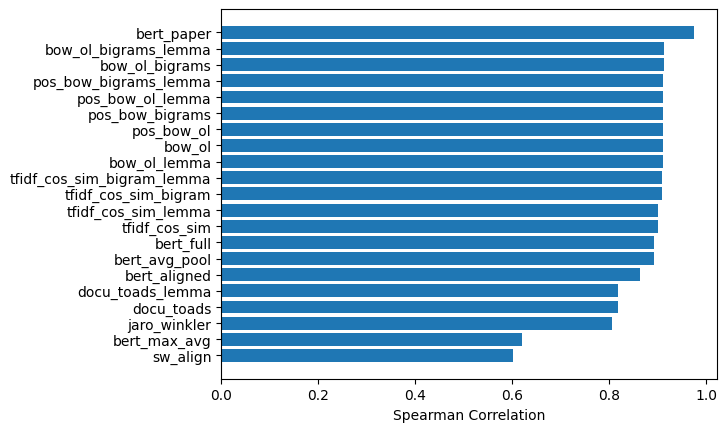

In [53]:
from matplotlib import pyplot as plt
plt.barh(eval_en["method"].to_numpy(), eval_en["corr"].to_numpy())
plt.xlabel("Spearman Correlation")


In [54]:
eval_de = evaluate_spearmanr(test_metrics_de, test_de["label"])

In [1]:
eval_de

NameError: name 'eval_de' is not defined

Text(0.5, 0, 'Spearman Correlation')

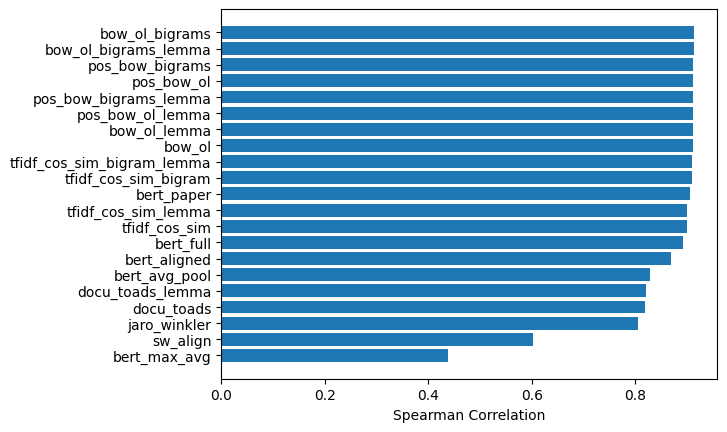

In [55]:
from matplotlib import pyplot as plt
plt.barh(eval_de["method"].to_numpy(), eval_de["corr"].to_numpy())
plt.xlabel("Spearman Correlation")

In [40]:
eval_en.write_csv("data/results/correlations_en.csv")
eval_de.write_csv("data/results/correlations_de.csv")

In [6]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

results = {}
for col in train_metrics.columns:
    clf = DecisionTreeClassifier(random_state=0, max_leaf_nodes=5)
    clf.fit(train_metrics[col].to_numpy().reshape(-1, 1), train["label"].to_numpy())

    y_pred = clf.predict(test_metrics[col].to_numpy().reshape(-1, 1))
    labels = test["label"].to_numpy()
    
    acc = accuracy_score(labels, y_pred)
    f1 = f1_score(labels, y_pred, average="macro")
    precision = precision_score(labels, y_pred, average="macro", zero_division=0)
    recall = recall_score(labels, y_pred, average="macro")
    results[col] = {
        "metric": col,
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }


    

In [340]:
confusion_matrix(labels, y_pred)

array([[466,   0,  17,   0,   0],
       [ 31,   0,  25,   4,   0],
       [ 27,   0,  56,  49,   4],
       [  2,   0,  19,  83,   1],
       [  0,   0,   0,   0, 160]])

In [332]:
test["label"].value_counts()

label,counts
i64,u32
4,160
3,105
0,483
1,60
2,136


[Text(0.5, 0.875, 'x[0] <= 0.764\ngini = 0.672\nsamples = 3305\nvalue = [1692, 210, 475, 367, 561]'),
 Text(0.25, 0.625, 'x[0] <= 0.631\ngini = 0.211\nsamples = 1859\nvalue = [1644, 130, 79, 6, 0]'),
 Text(0.125, 0.375, 'gini = 0.077\nsamples = 1478\nvalue = [1419, 39, 20, 0, 0]'),
 Text(0.375, 0.375, 'gini = 0.57\nsamples = 381\nvalue = [225, 91, 59, 6, 0]'),
 Text(0.75, 0.625, 'x[0] <= 1.0\ngini = 0.708\nsamples = 1446\nvalue = [48, 80, 396, 361, 561]'),
 Text(0.625, 0.375, 'x[0] <= 0.922\ngini = 0.631\nsamples = 856\nvalue = [48, 80, 379, 343, 6]'),
 Text(0.5, 0.125, 'gini = 0.619\nsamples = 413\nvalue = [47, 71, 232, 63, 0]'),
 Text(0.75, 0.125, 'gini = 0.49\nsamples = 443\nvalue = [1, 9, 147, 280, 6]'),
 Text(0.875, 0.375, 'gini = 0.113\nsamples = 590\nvalue = [0, 0, 17, 18, 555]')]

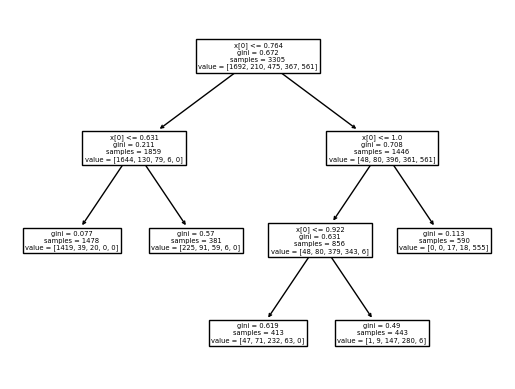

In [338]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plot_tree(clf)

In [300]:
results.values()

dict_values([{'accuracy': 0.7627118644067796, 'f1': 0.6208510684750875, 'precision': 0.6205473075931223, 'recall': 0.6216715381804896}, {'accuracy': 0.7436440677966102, 'f1': 0.5925509931821002, 'precision': 0.596103714123717, 'recall': 0.5900535866520521}, {'accuracy': 0.8114406779661016, 'f1': 0.6770380833354309, 'precision': 0.6817994165937874, 'recall': 0.6737078309584703}, {'accuracy': 0.8188559322033898, 'f1': 0.680153230783604, 'precision': 0.6807414561966956, 'recall': 0.6800864693703568}, {'accuracy': 0.6885593220338984, 'f1': 0.5465039303355419, 'precision': 0.54587128059086, 'recall': 0.5478254780172939}, {'accuracy': 0.746822033898305, 'f1': 0.6073215017775543, 'precision': 0.6101512790718022, 'recall': 0.6050213128729753}, {'accuracy': 0.7584745762711864, 'f1': 0.6123191406114158, 'precision': 0.6142585053659566, 'recall': 0.6111332359030569}, {'accuracy': 0.7171610169491526, 'f1': 0.5835321186149145, 'precision': 0.5829854839250393, 'recall': 0.5846669102423578}, {'accura

In [7]:
pl.from_dicts(list(results.values()))

metric,accuracy,f1,precision,recall
str,f64,f64,f64,f64
"""bert_aligned""",0.777542,0.582825,0.598075,0.581134
"""bert_avg_pool""",0.792373,0.592757,0.589551,0.599291
"""bert_max_avg""",0.662076,0.450413,0.554102,0.422731
"""bert_full""",0.791314,0.591546,0.575143,0.609746
"""tfidf_cos_sim""",0.806144,0.613613,0.612097,0.62867
"""sw_align""",0.602754,0.312034,0.370784,0.376812
"""docu_toads""",0.763771,0.539539,0.581896,0.543926
"""bow_ol""",0.824153,0.635002,0.618282,0.653091
"""pos_bow_ol""",0.820975,0.631337,0.627036,0.643845


EN

In [339]:
pl.from_dicts(list(results.values()))

metric,accuracy,f1,precision,recall
str,f64,f64,f64,f64
"""tfidf_cos_sim""",0.8125,0.61377,0.6003,0.628347
"""docu_toads""",0.831568,0.648159,0.647028,0.65282
"""bow_ol""",0.853814,0.657753,0.643068,0.680417
"""pos_bow_ol""",0.861229,0.670737,0.655576,0.688902
"""jaro_winkler""",0.753178,0.498827,0.476643,0.531014
"""bert_aligned""",0.808263,0.608551,0.603454,0.619411
"""bert_avg_pool""",0.8125,0.615658,0.611225,0.625742
"""bert_max_avg""",0.729873,0.528292,0.567965,0.514876
"""bert_full""",0.810381,0.607957,0.588911,0.633409


In [341]:
import swalign

In [414]:
alignment.matches / alignment.score

0.6772908366533864

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import MarianMTModel, MarianTokenizer

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
translated = model.generate(**tokenizer(["wie geht es dir?"," asdas"], return_tensors="pt", padding=True))

In [22]:
train["bill_text"][1]

'1 Inter departmental memorandum of agreement Section 4205 of the Indian Alcohol and Substance Abuse Prevention and Treatment Act of 1986 25 U S C 2411 is amended A in subsection a i in the matter preceding paragraph 1 I by striking the date of enactment of this subtitle and inserting the date of enactment of the Tribal Law and Order Act of 2009 and II by inserting the Attorney General after Secretary of the Interior ii in paragraph 2 A by inserting Bureau of Justice Assistance Substance Abuse and Mental Health Services Administration after Bureau of Indian Affairs iii in paragraph 4 by inserting Department of Justice Substance Abuse and Mental Health Services Administration after Bureau of Indian Affairs iv in paragraph 5 by inserting Department of Justice Substance Abuse and Mental Health Services Administration after Bureau of Indian Affairs v in paragraph 7 by inserting the Attorney General after Secretary of the Interior B in subsection c by inserting the Attorney General after Se

In [87]:
 train["bill_text"][4]

'Not later than 4 years after the date of enactment of this Act the Secretary shall submit to Congress a report that describes the actions that have been taken to carry out this section including 1 actions taken to address administrative and paperwork burdens identified as a result of compliance with section 119 i of the Child Nutrition and WIC Reauthorization Act of 2004 42 U S C 1766 note Public Law 108 265 2 administrative and paperwork burdens identified as a result of compliance with section 119 i of that Act for which no regulatory action or policy guidance has been taken 3 additional steps that the Secretary is taking or plans to take to address any administrative and paperwork burdens identified under subsection c 2 and paragraph 2 including A new or updated regulations policy guidance or technical assistance and B a timeframe for the completion of those steps and 4 recommendations to Congress for modifications to existing statutory authorities needed to address identified admi

In [33]:
0.9 * 512

460.8

In [2]:
model.forward(["hi"])

AttributeError: 'list' object has no attribute 'size'

In [362]:
list("hallo ich bin eine haus".split())

['hallo', 'ich', 'bin', 'eine', 'haus']

In [458]:
sw_align("du ich bin eine haus","hallo ich a")

AttributeError: 'Alignment' object has no attribute 'relative'

In [401]:
import uta_align.align as align
from inspect import getmembers, isfunction

In [402]:
dir(align)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [393]:
align

<module 'uta_align.align' (<_frozen_importlib_external.NamespaceLoader object at 0x7fa690082c10>)>

In [364]:
uta_align.align("hallo ich bin eine haus".split(),"hallo ich".split())

AttributeError: module 'uta_align' has no attribute 'align'

In [403]:
import swalign